In [1]:
import os
import sys
import numpy as np
import xarray as xr
import numpy as np
import cartopy.crs as ccrs
import cartopy.feature as feat
import xrft
from scipy import constants as co
from scipy import fft
import matplotlib.animation as animation
import matplotlib.pyplot as plt

import IPython.display as disp
from metpy import calc as mcalc
from metpy import interpolate as minterpolate
from metpy.units import units
import pandas as pd
import time
from ipywidgets import IntProgress, HTML
import shutil
from cdo import Cdo
from nco import Nco

plt.rcParams['animation.ffmpeg_path'] = '/home/hugo/mambaforge-pypy3/envs/env/bin/ffmpeg'
# cdo = Cdo()
# nco = Nco()
%matplotlib inline

In [2]:
DATADIR = "/scratch2/hugo/ERA5"
CLIMSTOR = "/mnt/climstor/ecmwf/era5/raw"

def filenamescm(y, m, d):  # Naming conventions of the files on climstor (why are they so different?)
    return [f"{CLIMSTOR}/ML/data/{str(y)}/P{str(y)}{str(m).zfill(2)}{str(d).zfill(2)}_{str(h).zfill(2)}" for h in range(0, 24, 6)]
def filenamecp(y, m, d):
    return [f"{CLIMSTOR}/PL/data/an_pl_ERA5_{str(y)}-{str(m).zfill(2)}-{str(d).zfill(2)}.nc"]  # returns iterable to have same call signature as filenamescl(y, m, d)
def filenamegeneric(y, m, folder):
    return [f"{DATADIR}/{folder}/{y}{str(m).zfill(2)}.nc"]

def _fn(date, which):
    if which == "ML":
        return filenamescm(date.year, date.month, date.day)
    elif which == "PL":
        return filenamecp(date.year, date.month, date.day)
    else:
        return filenamegeneric(date.year, date.month, which)
    
def fn(date, which):  # instead takes pandas.timestamp (or iterable of _) as input
    if isinstance(date, (list, np.ndarray, pd.DatetimeIndex)):
        filenames = []
        for d in date:
            filenames.extend(_fn(d, which))
        return filenames
    elif isinstance(date, pd.Timestamp):
        return _fn(date, which)
    else:
        raise RuntimeError(f"Invalid type : {type(date)}")

RADIUS = 6.371e6  # m
OMEGA = 7.2921e-5  # rad.s-1
KAPPA = 0.2854
R_SPECIFIC_AIR = 287.0500676

def degcos(x):
    return np.cos(x / 180 * np.pi)
def degsin(x):
    return np.sin(x / 180 * np.pi)

DATERANGEPL = pd.date_range("19590101", "20021231")
YEARSPL = np.unique(DATERANGEPL.year)
DATERANGEML = pd.date_range("19770101", "20211231")

In [10]:
### Lat and Int
def compute_JLI(da_Lat):
    LatI = da_Lat.argmax(dim="lat", skipna=True)
    Lat = xr.DataArray(da_Lat.lat[LatI.values.flatten()].values, coords={"time": da_Lat.time})
    Int = da_Lat.isel(lat=LatI)
    Latg = Lat.groupby("time.dayofyear")
    Latmean = Latg.mean(dim="time")
    ft = xrft.fft(Latmean, dim="dayofyear")
    ft[:int(len(ft) / 2) - 3] = 0
    ft[int(len(ft) / 2) + 3:] = 0
    Latsmooth = xrft.ifft(ft, dim="freq_dayofyear", true_phase=True, true_amplitude=True).real.assign_coords(dayofyear=Latmean.dayofyear)
    return Lat, Int, Latmean, Latsmooth

### JLI computations on scratch/ERA5/Wind/ files, following Woollings et al. 2010

In [131]:
# Step 1 : extraction of daily mean zonal wind, averaged over 4 p levels
files = np.asarray([filenamegeneric(y, m, "Woollings_daily") for y in YEARSPL for m in range(1, 13)]).flatten()
da = xr.open_mfdataset(files, concat_dim="time", combine='nested', engine="netcdf4")["u"].isel(lon=0).coarsen(lat=5, boundary="trim").mean()

In [6]:
# Alt : file from era40
da = xr.open_dataset("/scratch2/hugo/ERA40/UandVregridded2.nc")["u"]
da2 = da.interp(lat=np.arange(15, 76, 2.5), lon=(np.arange(-60,1,2.5)))
da2.mean(dim="lon").to_netcdf("/scratch2/hugo/ERA40/Woollings.nc")

In [5]:
da = xr.open_dataarray("/scratch2/hugo/ERA40/Woollings.nc")

In [6]:
# Lanczos filtering
def low_pass_weights(window, cutoff):  # shamefully stolen from https://github.com/liv0505/Lanczos-Filter
    """Calculate weights for a low pass Lanczos filter.
    Args:
    window: int
        The length of the filter window.
    cutoff: float
        The cutoff frequency in inverse time steps.
    """
    order = ((window - 1) // 2 ) + 1
    nwts = 2 * order + 1
    w = np.zeros([nwts])
    n = nwts // 2
    w[n] = 2 * cutoff
    k = np.arange(1., n)
    sigma = np.sin(np.pi * k / n) * n / (np.pi * k)
    firstfactor = np.sin(2. * np.pi * cutoff * k) / (np.pi * k)
    w[n-1:0:-1] = firstfactor * sigma
    w[n+1:-1] = firstfactor * sigma
    return w[1:-1]

window = 61
weights = xr.DataArray(low_pass_weights(window, 1 / 10), dims=["window"])
da2 = da.rolling(time=len(weights), center=True).construct("window").dot(weights).isel(time=range(int(window / 2), len(da.time) - int(window / 2)))

In [7]:
# Alternative : xrft filtering. Gives very similar results
da_fft = xrft.fft(da.chunk((len(da.time), 1, 1)), dim="time")
da_fft[np.abs(da_fft.freq_time) > 1 / 10 / 24 / 3600] = 0
da3 = xrft.ifft(da_fft, dim="freq_time", true_phase=True, true_amplitude=True).real.assign_coords(time=da.time)

/home/hugo/mambaforge-pypy3/envs/env/lib/python3.9/site-packages/xrft/xrft.py:546: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)


/home/hugo/mambaforge-pypy3/envs/env/lib/python3.9/site-packages/xrft/xrft.py:546: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)


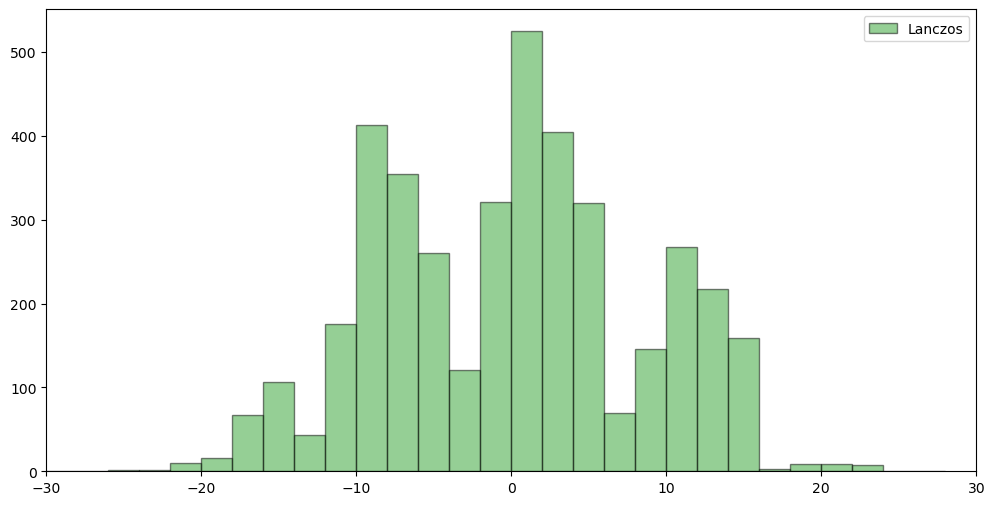

In [147]:
fig, ax = plt.subplots(figsize=(12,6))
# Lat, Int, Latmean, Latsmooth = compute_JLI(da3.load())
# timeseries = (Lat.groupby("time.dayofyear") - Latsmooth)
# timeseries = timeseries.isel(time=(timeseries.time.dt.season=="DJF"))
bins = np.arange(-30, 30, 2)
# hist = xr.plot.hist(timeseries, ax=ax, bins=bins, alpha=0.5, color="tab:blue", label="xrft")
Lat, Int, Latmean, Latsmooth = compute_JLI(da2.load())
timeseries = (Lat.groupby("time.dayofyear") - Latsmooth)
timeseries = timeseries.isel(time=(timeseries.time.dt.season=="DJF"))
hist = xr.plot.hist(timeseries, ax=ax, bins=bins, alpha=0.5, color="tab:green", label="Lanczos", edgecolor="black")
ax.set_xlim([-30,30])
ax.legend()

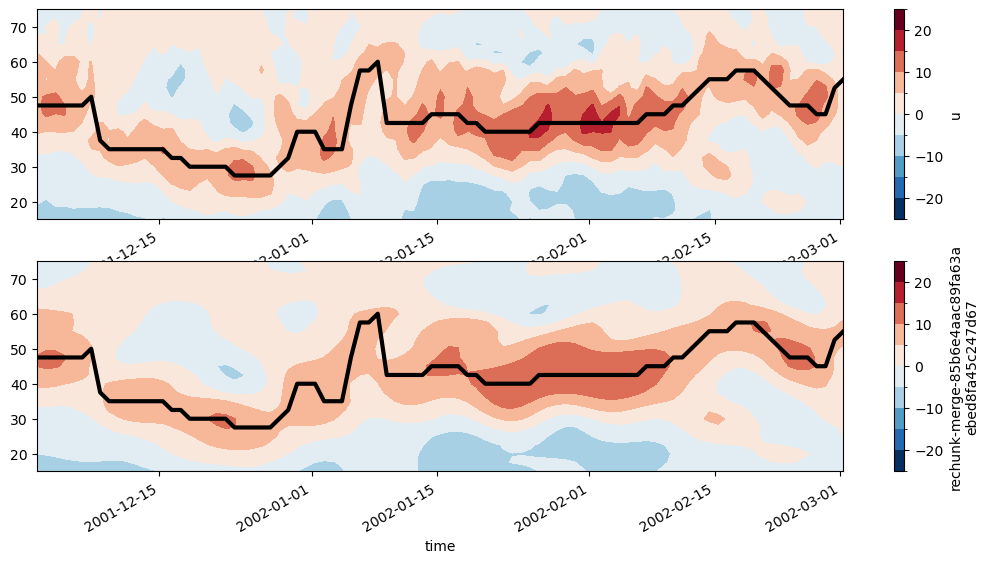

In [12]:
# Trying to reproduce figure 3 of Woollings et al. 2010
fig, axes = plt.subplots(2, 1, figsize=(13, 6))
winter0102 = pd.date_range("2001-12-01 09:00:00", "2002-03-01 09:00:00", freq="1D")
levels = np.arange(-25, 26, 5)
da.sel(time=winter0102).transpose().plot.contourf(ax=axes[0], levels=levels)
da3.sel(time=winter0102).transpose().plot.contourf(ax=axes[1], levels=levels)
Lat.sel(time=winter0102).plot(ax=axes[0], color="black", lw=3)
Lat.sel(time=winter0102).plot(ax=axes[1], color="black", lw=3)

In [139]:
dafull = xr.open_dataset("/scratch2/hugo/ERA40/UandVregridded2.nc").isel(time=range(int(window / 2), len(da.time) - int(window / 2)), lat=np.arange(4, 75), lon=np.arange(60, 200))
dafull = dafull.isel(time=(dafull.time.dt.season=="DJF"))

In [140]:
dafull["speed"] = np.sqrt(dafull["u"] ** 2 + dafull["v"] ** 2)

In [141]:
peakind = [i for i in range(len(bins)) if bins[i] in [-16, 0, 10]]

In [142]:
import matplotlib.path as mpath
def make_boundary_path(minlon,maxlon,minlat,maxlat,n=100):
    '''
    return a matplotlib Path whose points are a lon-lat box given by
    the input parameters
    '''

    boundary_path = []
    #North (E->W)
    edge = [np.linspace(minlon,maxlon,n), np.full(n,maxlat)]
    boundary_path += [[i,j] for i,j in zip(*edge)]

    #West (N->S)
    edge = [np.full(n,maxlon),np.linspace(maxlat,minlat,n)]
    boundary_path += [[i,j] for i,j in zip(*edge)]

    #South (W->E)
    edge = [np.linspace(maxlon,minlon,n), np.full(n,minlat)]
    boundary_path += [[i,j] for i,j in zip(*edge)]

    #East (S->N)
    edge = [np.full(n,minlon),np.linspace(minlat,maxlat,n)]
    boundary_path += [[i,j] for i,j in zip(*edge)]

    boundary_path = mpath.Path(boundary_path)

    return boundary_path

def make_boundary_path_wrapper(lon, lat,n=100):
    return make_boundary_path(
        np.amin(lon), np.amax(lon), 
        np.amin(lat), np.amax(lat), 
        n
    )

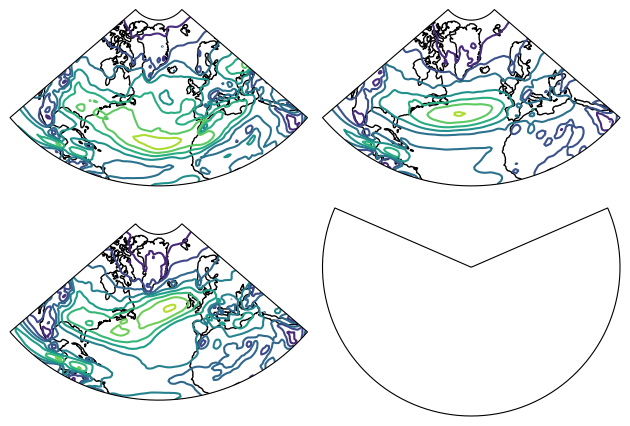

In [144]:
lon, lat = dafull.lon.values, dafull.lat.values
digitized = np.digitize(timeseries, bins=bins)
transform = ccrs.LambertConformal(
    central_longitude=np.mean(lon),
)
projection = transform
fig, axes = plt.subplots(
    2, 2, tight_layout=True, 
    subplot_kw={"projection": projection}
)
axes = axes.flatten()
for i in range(3):
    ax = axes[i]
    thisda = dafull.isel(time=digitized==peakind[i]).mean(dim="time")
    ax.coastlines()
    ax.set_xmargin(0)
    ax.set_ymargin(0)
    hihi = ax.contour(
        lon[:, None] * np.ones(len(lat)),
        lat[None, :] * np.ones(len(lon))[:, None],
        thisda["speed"].transpose(),
        transform=ccrs.PlateCarree(),
    )
    ax.set_boundary(make_boundary_path_wrapper(lon, lat), transform=ccrs.PlateCarree())

### Barriopedro, (package to daint)

In [3]:
# on cal4
files = np.asarray([filenamegeneric(y, m, "Barriopedro") for y in YEARSPL for m in range(1, 13)]).flatten()
da = xr.open_mfdataset(files, concat_dim="time", combine='nested', engine="netcdf4")["u"]
da_fft = xrft.fft(da.chunk((len(da.time), 1, 1)), dim="time")
da_fft[np.abs(da_fft.freq_time) > 1 / 10 / 24 / 3600] = 0
da2 = xrft.ifft(da_fft, dim="freq_time", true_phase=True, true_amplitude=True).real.assign_coords(time=da.time)
da3 = da2.rolling(lon=60, center=True).mean().isel(lon=np.arange(60, 181))
da2 = da2.rename("u")
da2.attrs["unit"] = "m/s"
da3 = da3.rename("u")
da3.attrs["unit"] = "m/s"
da.to_netcdf(f"{DATADIR}/da.nc")
da3.to_netcdf(f"{DATADIR}/da2.nc")
da2.to_netcdf(f"{DATADIR}/da3.nc")

In [ ]:
to_plot = [da.isel(lon=range(60, 181)), da2.isel(lon=range(60, 181)), da3]
titles = ["original", "filtered", "smoothed"]
levels = [8, 8, 8]
fig, axes, plt_rej, animate_all = create_plot(to_plot, titles, levels, twolevel=False, startindex=0)

In [70]:
ani = animation.FuncAnimation(fig, animate_all, frames=50)
HTML(ani.to_html5_video())

HTML(value='<video width="1050" height="600" controls autoplay loop>\n  <source type="video/mp4" src="data:vid…

In [17]:
# Daint
da3 = xr.open_dataset("/scratch/snx3000/hbanderi/data/BarriopedroFull.nc")["rechunk-merge-8f6632f91adea450d185f6f0a83ee58c"].rename("u")
da3.attrs["unit"] = "m/s"

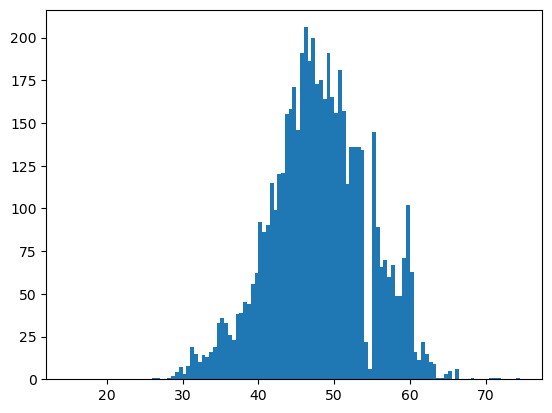

In [5]:
fig, ax = plt.subplots()
# timeseries = (Lat.groupby("time.dayofyear") - Latsmooth)
timeseries = Lat
timeseries = timeseries.isel(time=np.isin(timeseries.time.dt.month, [1, 2, 12]))
hist = xr.plot.hist(timeseries, ax=ax, bins=np.arange(15, 75, .5))
# ax.vlines(0, 0,  np.max(hist[0]), color="r", ls="--")
plt.show()

In [6]:
### Shar, Latn, Lats, 

Shar = (Int - da_Lat.mean(dim="lat")).rename("Shar")

this = da_Lat - Shar / 2
ouais = np.where(this.values[:, 1:] * this.values[:, :-1] < 0)
hist = np.histogram(ouais[0], bins=np.arange(len(da_Lat.time) + 1))[0]
cumsumhist = np.append([0], np.cumsum(hist)[:-1])
Lats = xr.DataArray(da_Lat.lat.values[ouais[1][cumsumhist]], coords={"time": da_Lat.time})
Latn = xr.DataArray(da_Lat.lat.values[ouais[1][cumsumhist + hist - 1]], coords={"time": da_Lat.time})
Latn[Latn < Lat] = da_Lat.lat[-1]
Lats[Lats > Lat] = da_Lat.lat[0]

In [72]:
### Tilt

def bound(da, candidate, index, twodelta):
    return np.min([np.max([candidate, da[:, index] - twodelta], axis=0), da[:, index] + twodelta], axis=0)
trackedLats = xr.DataArray(np.zeros((len(da3.time), len(da3.lon))), coords={"time": da3.time, "lon": da3.lon})
lats = da3.lon.values
twodelta = 1.
midpoint = int(len(lats) / 2)
trackedLats[:, midpoint] = Lat
iterator = zip(reversed(range(midpoint)), range(midpoint + 1, len(lats)))
for lonw, lone in iterator:
    candidatew = xr.DataArray(da3.lat.values[(da3.isel(lon=lonw)).argmax(dim="lat").values], coords={"time": da3.time})
    trackedLats[:, lonw] = bound(trackedLats, candidatew, lonw + 1, twodelta)
    candidatee = xr.DataArray(da3.lat.values[(da3.isel(lon=lone)).argmax(dim="lat").values], coords={"time": da3.time})
    trackedLats[:, lone] = bound(trackedLats, candidatee, lone - 1, twodelta)
Tilt = trackedLats.polyfit(dim="lon", deg=1).sel(degree=1)["polyfit_coefficients"]

In [83]:
### Lon

Intlambda = da3.sel(lat=trackedLats)
Intlambdasq = Intlambda * Intlambda
lons = xr.DataArray(da3.lon.values[None, :] * np.ones(len(da3.time))[:, None], coords={"time": da3.time, "lon": da3.lon})
Lon = (lons * Intlambdasq).sum(dim="lon") / Intlambdasq.sum(dim="lon")

In [84]:
### Lonw, Lone

In [95]:
### Dep
phistarl = xr.DataArray(da3.lat.values[da3.argmin(dim="lat").values], coords={"time": da3.time, "lon": da3.lon})
Dep = np.sqrt((phistarl - trackedLats) ** 2).sum(dim="lon")

### Create_plot

In [65]:
def create_plot(to_plot, titles, levels, twolevel=False, startindex=-1):
    # Figure
    transform = ccrs.PlateCarree()
    projection = transform
    if twolevel:
        fig, axes = plt.subplots(
            2,
            int(len(to_plot) / 2),
            subplot_kw={"projection": projection}, constrained_layout=True #, figsize=(6 * len(to_plot) // 2, 13)
        )
    else:
        fig, axes = plt.subplots(
            1, len(to_plot), subplot_kw={"projection": projection}, constrained_layout=True, figsize=(3.5 * len(to_plot), 6)
        )
    axes = np.atleast_1d(axes)
    axes = axes.flatten()

    # Add coastline and boarders
    coastline = feat.NaturalEarthFeature(
        "physical", "coastline", "10m", edgecolor="black", facecolor="none"
    )
    borders = feat.NaturalEarthFeature(
        "cultural",
        "admin_0_boundary_lines_land",
        "10m",
        edgecolor="grey",
        facecolor="none",
    )
    plt_rej = []
    cbar = [None] * len(to_plot)
    for j in range(len(to_plot)):
        ax = axes[j]
        plt_rej.append(
            ax.contourf(
                to_plot[j]["lon"].values[:, None] * np.ones(len(to_plot[j]["lat"])),
                to_plot[j]["lat"].values[None, :] * np.ones(len(to_plot[j]["lon"]))[:, None],
                to_plot[j].isel(time=startindex).transpose(),
                levels=levels[j],
                transform=transform,
                transform_first=True,
                # cmap=cmap,
                zorder=0,
            )
        )

        ax.add_feature(coastline)
        ax.add_feature(borders)
        ax.set_xmargin(0)
        ax.set_ymargin(0)
        ax.set_title(f"Day {startindex}, {titles[j]}, g.a : {np.mean(to_plot[j][startindex]):.2f}")

        cbar[j] = fig.colorbar(plt_rej[j], ax=ax,fraction=0.046, pad=0.04)

    def animate_all(i):
        global plt_rej
        for j in range(len(to_plot)):
            ax = axes[j]
            for c in plt_rej[j].collections:
                c.remove()
            plt_rej[j] = ax.contourf(
                to_plot[j]["lon"].values[:, None] * np.ones(len(to_plot[j]["lat"])),
                to_plot[j]["lat"].values[None, :] * np.ones(len(to_plot[j]["lon"]))[:, None],
                to_plot[j].isel(time=i).transpose(),
                levels=levels[j],
                transform=transform,
                transform_first=True,
                # cmap=cmap,
                zorder=0,
            )
            ax.set_title(f"Day {i + 1}, {titles[j]}, g.a : {np.mean(to_plot[j][i]):.2f}")
            cbar[j] = fig.colorbar(plt_rej[j], cax=fig.axes[len(axes) + j])
        return plt_rej

    return fig, axes, plt_rej, animate_all

### Fetch

In [ ]:
# create yearly files containing u(700-75-925), compliant with Barripedro et. al (2022); Woollings (2010)

# f1 = IntProgress(min=0, max=len(YEARSPL) * 12)
# display(f1)
for year in YEARSPL:
    for month in range(1, 13):
        fn = filenamegeneric("Woollings", year, month)
        if os.path.isfile(fn):
            # f1.value += 1
            continue
        to_merge = []
        for d in DATERANGEPL[np.logical_and(DATERANGEPL.year == year, DATERANGEPL.month == month)]:    
            to_merge.extend(fncp(d))
        xr.open_mfdataset(
            to_merge, 
            drop_variables=[v for v in longname if v != "u"], 
            engine="scipy",
        ).sel(
            level=[700.0, 750.0, 800.0, 850.0, 900.0]
        ).to_netcdf(fn)
        # f1.value += 1

In [ ]:
longname = {
    "u": "U-component of wind",
    "v": "V-component of wind",
    "w": "W-component of wind",
    "z": "Geopotential",
    "t": "Temperature",
    "vo": "Relative vorticity",
    "q": "Specific humidity",
    "r": "relative humidity"
    
}
variablemap = {
    f"{var}{lev}": [var, "PL", lev, f"{longname[var]} at {lev} hPa"] 
    for var in ["u", "v", "vo"] 
    for lev in range(700, 901, 50)
}
var = "z"
vm2 = {
    f"{var}{lev}": [var, "PL", lev, f"{longname[var]} at {lev} hPa"] 
    for lev in [300, 500]
}

variablemap.update(vm2)
variablemap["t850"] = ["t", "PL", 850, f"{longname['t']} at 850 hPa"]

### PV calculations

In [ ]:
ds = xr.open_mfdataset(fn(DATERANGEML[0], which="ML")[:1], combine="nested", concat_dim="time")
ds["P"] = (ds["hybm"] * ds["PS"] + ds["hyam"]).isel(lev_2=0).drop("lev_2").rename({"nhym": "lev"})
ds["P"].attrs["units"] = "Pa"
ds["T"].attrs["units"] = "celsius"
ds = ds.isel(lat=range(1, len(ds.lat) -1)).metpy.quantify()
ds["THETA"] = mcalc.potential_temperature(ds["P"], ds["T"])
ds["PV"] = mcalc.potential_vorticity_baroclinic(ds["THETA"], ds["P"], ds["U"], ds["V"], x_dim=3, y_dim=2, vertical_dim=1)

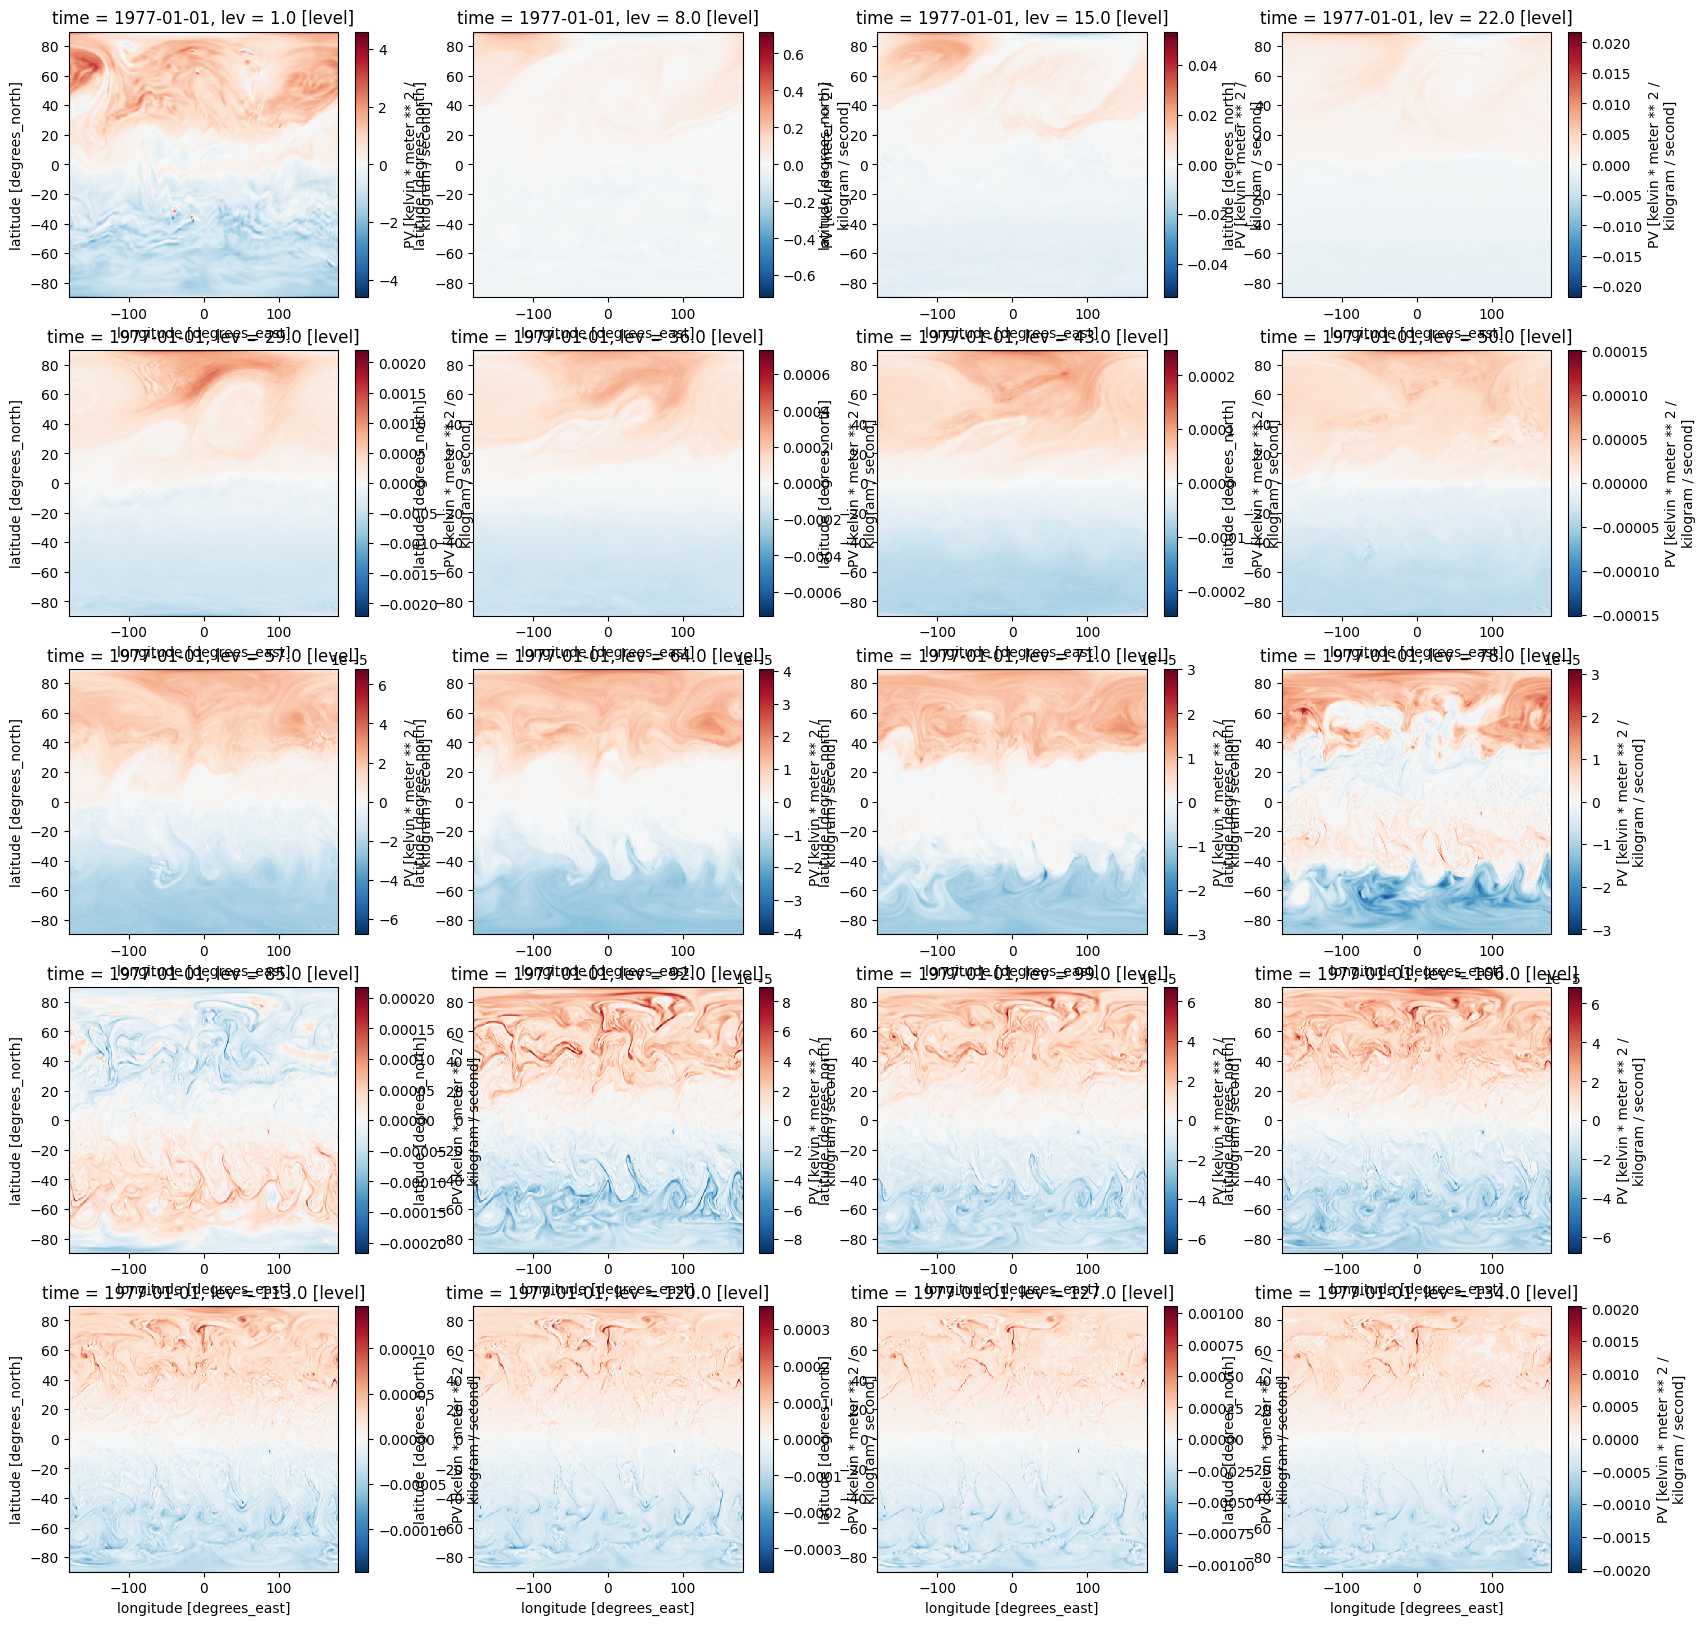

In [ ]:
fig, axes = plt.subplots(5, 4, figsize=[20, 20])
axes = axes.flatten()
for l, k in enumerate(range(0, 137, int(137/20) + 1)):
    ds["PV"].isel(lev=k, time=0).plot(ax=axes[l])

In [ ]:
dims = ["time", "lat", "lon"]
ds["U_2PVU"] = xr.DataArray(np.empty([len(ds["T"].coords[dim]) for dim in dims]), dims=dims, coords={dim: ds["T"].coords[dim] for dim in dims})
ds["V_2PVU"] = ds["U_2PVU"].copy()
for ti, t in enumerate(ds.time):
    this_ds = ds.isel(time=ti)
    for w in ["U", "V"]:
        ds[f"{w}_2PVU"][ti, :, :] = minterpolate.interpolate_to_isosurface(this_ds["PV"].values, this_ds[w].values, 2e-6)

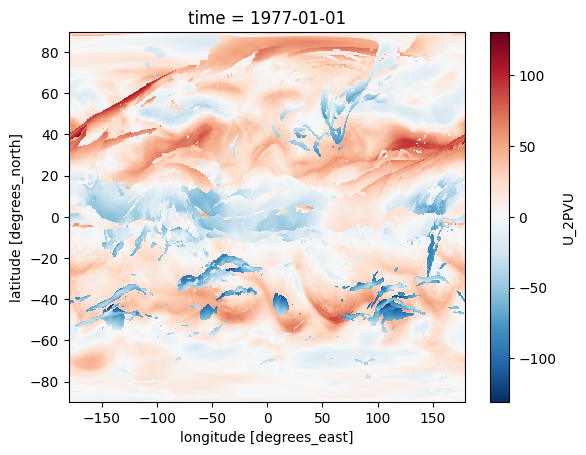

In [ ]:
ds["U_2PVU"].plot()

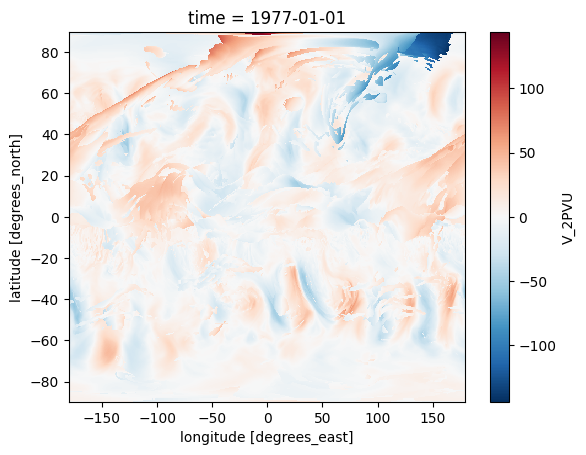

In [ ]:
ds["V_2PVU"].plot()